In [19]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from PIL import Image

In [20]:
excel_file="data.xlsx"

In [21]:
data = pd.read_excel(excel_file, sheet_name=None, skiprows=1)
peach_data = data["Lemon"]

In [22]:
peach_data.columns

Index(['Date', 'Sample name', 'File name', 'Initial (gram)', 'Waste (gram)',
       '% Waste', 'Unnamed: 6', 'Date.1', 'Sample name.1', 'File name.1',
       'Initial (gram).1', 'Waste (gram).1', '% Waste.1'],
      dtype='object')

In [23]:
peach_data_top = peach_data[["File name", "% Waste"]]
peach_data_top.dropna(inplace=True)

peach_data_side = peach_data[["File name.1", "% Waste.1"]]

peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
peach_data_side.dropna(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_21352\4094097339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peach_data_top.dropna(inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21352\4094097339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21352\4094097339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [24]:
peach_data_top

,File name,% Waste
0,20240104_lemon_01_top_01,30.931677
1,20240104_lemon_02_top_01,31.090487
2,20240104_lemon_03_top_01,36.273818
3,20240104_lemon_04_top_01,100.000000
4,20240104_lemon_05_top_01,7.618284
...,...,...
96,20240418_lemon_02_top_01,100.000000
97,20240418_lemon_03_top_01,89.528433
98,20240419_lemon_01_top_01,61.080222
99,20240419_lemon_02_top_01,53.664787


In [25]:
peach_data_side

,File name,% Waste
0,20240104_lemon_01_side_01,30.931677
1,20240104_lemon_02_side_01,31.090487
2,20240104_lemon_03_side_01,36.273818
3,20240104_lemon_04_side_01,100.000000
4,20240104_lemon_05_side_01,7.618284
...,...,...
96,20240418_lemon_02_side_01,100.000000
97,20240418_lemon_03_side_01,89.528433
98,20240419_lemon_01_side_01,61.080222
99,20240419_lemon_02_side_01,53.664787


In [26]:
data = pd.concat([peach_data_side,peach_data_top], axis=0)

In [27]:
data

,File name,% Waste
0,20240104_lemon_01_side_01,30.931677
1,20240104_lemon_02_side_01,31.090487
2,20240104_lemon_03_side_01,36.273818
3,20240104_lemon_04_side_01,100.000000
4,20240104_lemon_05_side_01,7.618284
...,...,...
96,20240418_lemon_02_top_01,100.000000
97,20240418_lemon_03_top_01,89.528433
98,20240419_lemon_01_top_01,61.080222
99,20240419_lemon_02_top_01,53.664787


<Axes: >

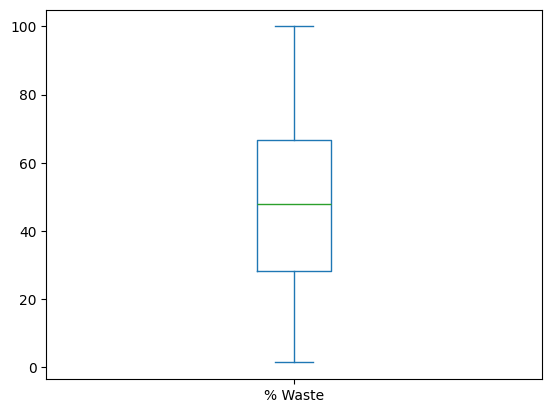

In [28]:
data.plot.box()

In [29]:
actual_waste = data["% Waste"]
baseline_prediction = np.mean(data["% Waste"]) 

# Generate baseline predictions for all samples
baseline_predictions = np.full_like(actual_waste, baseline_prediction)

# Calculate RMSE for baseline predictions
baseline_rmse = np.sqrt(mean_squared_error(actual_waste, baseline_predictions))



print("Baseline RMSE:", baseline_rmse)

Baseline RMSE: 28.443176638855437


Extraction Color Histograms and Training Models

In [30]:
# Function to extract histogram features from image files
def extract_histogram(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise Exception(f"Failed to open image '{image_path}'")
        hist = cv2.calcHist(
            [image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]
        )
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    except Exception as e:
        print(f"Error processing image '{image_path}': {e}")
        return None


# Extracting histogram features from filenames
peach_folder = "lemon"
data["Histogram"] = data["File name"].apply(
    lambda x: extract_histogram(os.path.join(peach_folder, x + ".jpg"))
)

# Remove rows where the histogram extraction failed
data = data.dropna()

# Preparing features and target
X = np.vstack(data["Histogram"]).astype(float)
y = data["% Waste"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Training regression models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}: RMSE = {rmse}")

Error processing image 'lemon\20240122_lemon_01_side_01.jpg': Failed to open image 'lemon\20240122_lemon_01_side_01.jpg'
Error processing image 'lemon\20240326_lemon_01_side_01.jpg': Failed to open image 'lemon\20240326_lemon_01_side_01.jpg'
Error processing image 'lemon\20240327_lemon_01_side_01.jpg': Failed to open image 'lemon\20240327_lemon_01_side_01.jpg'
Error processing image 'lemon\20240327_lemon_02_side_01.jpg': Failed to open image 'lemon\20240327_lemon_02_side_01.jpg'
Error processing image 'lemon\20240327_lemon_03_side_01.jpg': Failed to open image 'lemon\20240327_lemon_03_side_01.jpg'
Error processing image 'lemon\20240404_lemon_01_side_01.jpg': Failed to open image 'lemon\20240404_lemon_01_side_01.jpg'
Error processing image 'lemon\20240404_lemon_02_side_01.jpg': Failed to open image 'lemon\20240404_lemon_02_side_01.jpg'
Error processing image 'lemon\20240404_lemon_03_side_01.jpg': Failed to open image 'lemon\20240404_lemon_03_side_01.jpg'
Error processing image 'lemon\20

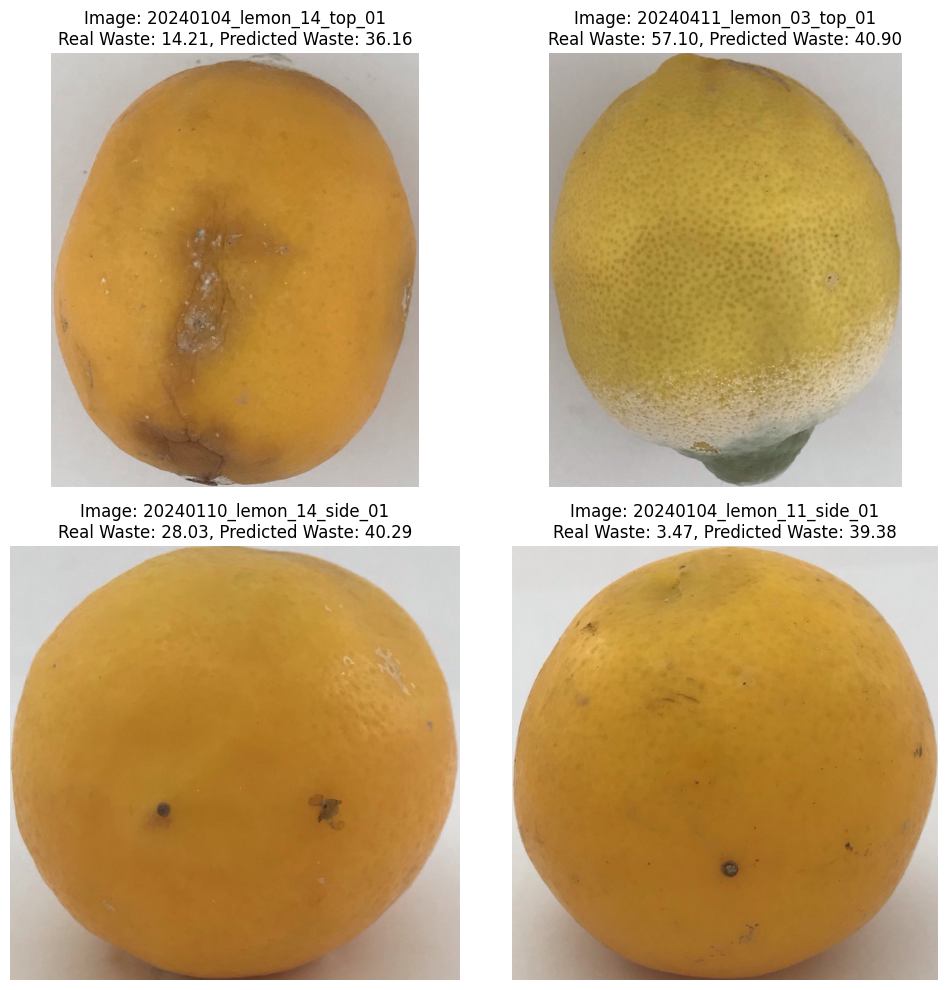

In [31]:

test_filenames = random.sample(
    data["File name"].tolist(), 4
)  # Select 4 images for a 2x2 grid
test_image_paths = [
    os.path.join(peach_folder, f"{filename}.jpg") for filename in test_filenames
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Display real and predicted waste percentages for test images
for ax, image_path, filename in zip(axes.flatten(), test_image_paths, test_filenames):
    real_waste_percentage = data[data["File name"] == filename]["% Waste"].values[0]
    hist = extract_histogram(image_path)
    if hist is not None:
        hist = hist.reshape(1, -1)
        predicted_waste = model.predict(hist)[0]

        # Load and display the image using Matplotlib
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(
            f"Image: {filename}\nReal Waste: {real_waste_percentage:.2f}, Predicted Waste: {predicted_waste:.2f}"
        )
        ax.axis("off")  # Hide axes
    else:
        print(f"Image: {image_path}, Histogram extraction failed")

# Adjust layout
plt.tight_layout()
plt.show()

## DL Based Regression

In [32]:
train_df, test_df = train_test_split(data.dropna(), test_size=0.2, random_state=42)

train_df = train_df[
    train_df["File name"].apply(
        lambda x: os.path.exists(os.path.join("lemon", x + ".jpg"))
    )
]
test_df = test_df[
    test_df["File name"].apply(
        lambda x: os.path.exists(os.path.join("lemon", x + ".jpg"))
    )
]


val_df, test_df = train_test_split(test_df,test_size=0.5, random_state=42)

len(train_df),len(test_df), len(val_df)

(145, 19, 18)

In [33]:
train_df

,File name,% Waste,Histogram
73,20240411_lemon_01_side_01,100.000000,"[0.0, 1.6079033e-05, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
75,20240411_lemon_03_side_01,57.100809,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
31,20240110_lemon_14_side_01,28.027682,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,20240104_lemon_13_side_01,1.351351,"[0.0, 0.0003000611, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
41,20240117_lemon_10_side_01,74.376200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
15,20240104_lemon_16_top_01,3.706897,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14,20240104_lemon_15_side_01,3.104027,"[0.0, 2.3250488e-05, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,20240104_lemon_02_top_01,31.090487,"[0.0, 6.787742e-05, 3.572496e-06, 0.0, 0.0, 0...."
96,20240418_lemon_02_top_01,100.000000,"[5.3070293e-05, 0.0002750006, 0.0, 0.0, 0.0, 0..."


In [34]:
from torchvision import transforms


class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0] + ".jpg")
        if not os.path.exists(img_name):
            return None, None
        image = cv2.imread(img_name)
        label = self.dataframe.iloc[idx, 1]

        # Convert BGR image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


# Define image transformations
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Define datasets and data loaders
train_dataset = CustomDataset(train_df, "lemon", transform=train_transforms)
test_dataset = CustomDataset(test_df, "lemon", transform=test_transforms)
val_dataset = CustomDataset(val_df, "lemon", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


class RegressionModel(nn.Module):

    def __init__(self):

        super(RegressionModel, self).__init__()
        resnet = torchvision.models.resnet101(pretrained=True)
        self.features = nn.Sequential(
            *list(resnet.children())[:-1]
        )  # Remove the last fully connected layer
        self.regressor1 = nn.Linear(
            2048, 256
        )  # Replace the last layer with a regression layer
        self.regressor2 = nn.Linear(256, 1)

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor1(x)
        x = self.regressor2(x)
        return x


# Define the model
model = RegressionModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=5, verbose=True
)

# Early stopping
best_val_loss = float("inf")
patience = 15
counter = 0
best_model_weights = None

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False
    ):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs.squeeze(), labels.float())
        val_running_loss += val_loss.item() * inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_epoch_loss)

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        # Save the best model weights
        best_model_weights = model.state_dict()

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

# Load the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

torch.save(model.state_dict(), "lemon_regression_model.pth")
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():

    for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        predictions.extend(outputs.squeeze().tolist())

        true_labels.extend(labels.tolist())

mse = mean_squared_error(true_labels, predictions)
print(f"Root Mean Squared Error on Test Set: {np.sqrt(mse):.4f}")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/100:  90%|████

Epoch [1/100], Training Loss: 2419.4287
Epoch [1/100], Validation Loss: 1662.5663


Epoch [2/100], Training Loss: 728.4914
Epoch [2/100], Validation Loss: 1178.6380


Epoch [3/100], Training Loss: 325.5387
Epoch [3/100], Validation Loss: 329.5413


Epoch [4/100], Training Loss: 264.4280
Epoch [4/100], Validation Loss: 454.7405


Epoch [5/100], Training Loss: 313.2080
Epoch [5/100], Validation Loss: 510.5872


Epoch [6/100], Training Loss: 268.4214
Epoch [6/100], Validation Loss: 212.0370


Epoch [7/100], Training Loss: 192.4996
Epoch [7/100], Validation Loss: 377.6694


Epoch [8/100], Training Loss: 163.4991
Epoch [8/100], Validation Loss: 269.8986


Epoch [9/100], Training Loss: 135.9434
Epoch [9/100], Validation Loss: 240.2388


Epoch [10/100], Training Loss: 107.4382
Epoch [10/100], Validation Loss: 366.8032


Epoch [11/100], Training Loss: 137.9211
Epoch [11/100], Validation Loss: 377.1522


Epoch [12/100], Training Loss: 151.7984
Epoch [12/100], Validation Loss: 197.6412


Epoch [13/100], Training Loss: 170.6646
Epoch [13/100], Validation Loss: 419.6298


Epoch [14/100], Training Loss: 154.0691
Epoch [14/100], Validation Loss: 218.4207


Epoch [15/100], Training Loss: 109.0376
Epoch [15/100], Validation Loss: 298.5444


Epoch [16/100], Training Loss: 135.2862
Epoch [16/100], Validation Loss: 227.8625


Epoch [17/100], Training Loss: 142.4021
Epoch [17/100], Validation Loss: 293.5732


Epoch [18/100], Training Loss: 165.9418
Epoch [18/100], Validation Loss: 219.3168


Epoch [19/100], Training Loss: 90.7384
Epoch [19/100], Validation Loss: 240.4256


Epoch [20/100], Training Loss: 111.6612
Epoch [20/100], Validation Loss: 288.8059


Epoch [21/100], Training Loss: 129.9635
Epoch [21/100], Validation Loss: 285.2039


Epoch [22/100], Training Loss: 80.9710
Epoch [22/100], Validation Loss: 272.4460


Epoch [23/100], Training Loss: 67.5033
Epoch [23/100], Validation Loss: 230.5091


Epoch [24/100], Training Loss: 93.4052
Epoch [24/100], Validation Loss: 287.4750


Epoch [25/100], Training Loss: 90.0627
Epoch [25/100], Validation Loss: 321.6883


Epoch [26/100], Training Loss: 117.7768
Epoch [26/100], Validation Loss: 264.0590


Epoch [27/100], Training Loss: 78.9947
Epoch [27/100], Validation Loss: 278.0391
Early stopping...


Root Mean Squared Error on Test Set: 15.4466


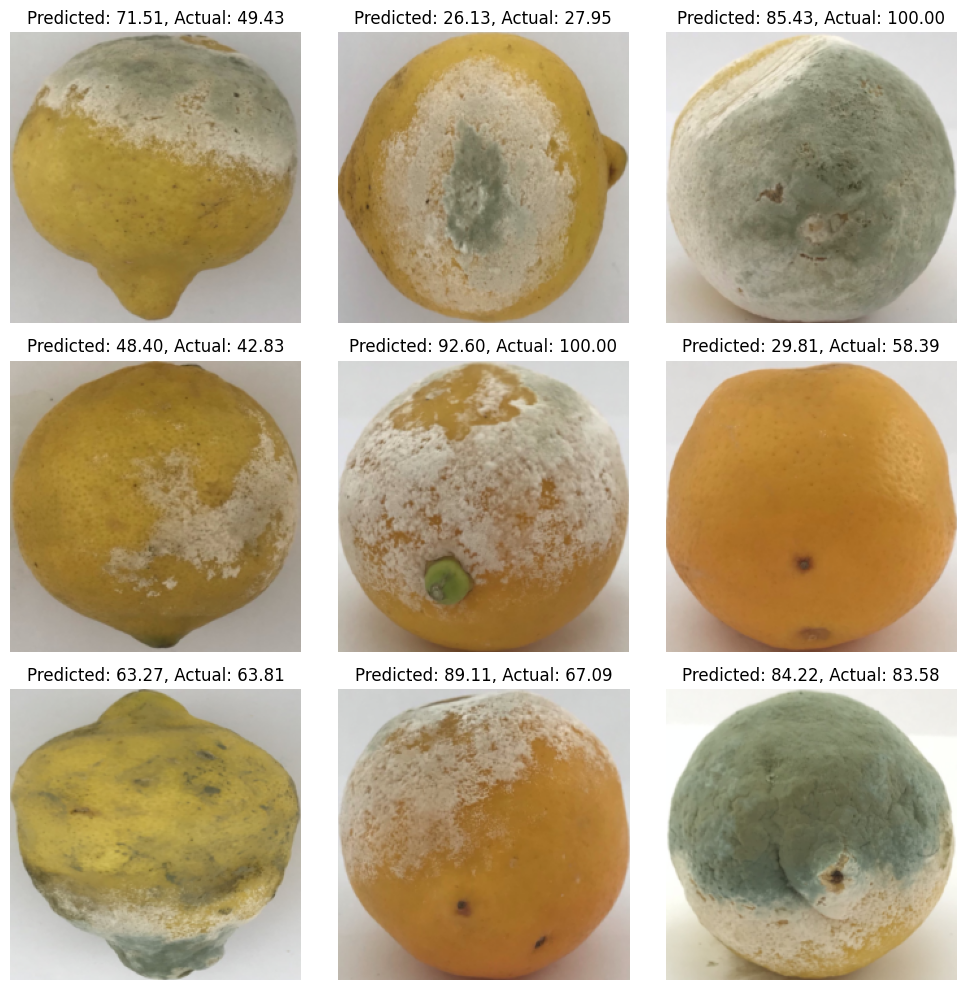

In [35]:
# Evaluation
model.eval()
with torch.no_grad():
    # Get random indices for 4 test images
    indices = np.random.choice(len(test_dataset), size=9, replace=False)

    # Create a subplot
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i, idx in enumerate(indices):
        inputs, label = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        output = model(inputs)
        prediction = output.item()

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = inputs.squeeze().permute(1, 2, 0).cpu().numpy()
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        # Display the image
        axs[i // 3, i % 3].imshow(img)
        axs[i // 3, i % 3].set_title(
            f"Predicted: {prediction:.2f}, Actual: {label:.2f}"
        )
        axs[i // 3, i % 3].axis("off")

    plt.tight_layout()
    plt.show()